In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quality-prediction-in-a-mining-process/MiningProcess_Flotation_Plant_Database.csv


In [2]:
df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', decimal=',')
df['date'] = pd.to_datetime(df['date'])
df.head(2)

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31


In [3]:
print('Shape: ', df.shape)
print('Columns: ')
print(df.columns)
print('Datatypes:')
print(df.dtypes)

Shape:  (737453, 24)
Columns: 
Index(['date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')
Datatypes:
date                            datetime64[ns]
% Iron Feed                            float64
% Silica Feed                          float64
Starch Flow                            float64
Amina Flow                             float64
Ore Pulp Flow                       

Show the hours with less than 180 records (missing data within the hour).

In [4]:
counts = df.groupby('date').count()
counts[counts['% Iron Feed'] < 180]

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174
2017-04-10 00:00:00,179,179,179,179,179,179,179,179,179,179,...,179,179,179,179,179,179,179,179,179,179


Luckily only the first hour is missing 6 data points and one other hour is missing one. When creating an accurate time series index, we will arbitrarily take out the first couple 20 second intervals to match the amount of records found for those hours. 

We will now create the 20 second frequency Datetime Index.

In [5]:
# get a series of unique hourly timestamps
hours = pd.Series(df['date'].unique())
hours.index = hours
len(hours)

4097

In [6]:
# create a date time index from the first to the last hour included in the date column
date_range = pd.date_range(start=df.iloc[0,0], end='2017-09-09 23:59:40', freq='20S')
# remove first couple observations consistent with the counts exploration above
date_range = date_range[6:]
date_range[-5:]

DatetimeIndex(['2017-09-09 23:58:20', '2017-09-09 23:58:40',
               '2017-09-09 23:59:00', '2017-09-09 23:59:20',
               '2017-09-09 23:59:40'],
              dtype='datetime64[ns]', freq='20S')

In [7]:
# create lists from both the hours series and the new datetime index
hours_list = hours.index.format()
print(hours_list[:5])
seconds_list = date_range.format()
print(seconds_list[:5])

['2017-03-10 01:00:00', '2017-03-10 02:00:00', '2017-03-10 03:00:00', '2017-03-10 04:00:00', '2017-03-10 05:00:00']
['2017-03-10 01:02:00', '2017-03-10 01:02:20', '2017-03-10 01:02:40', '2017-03-10 01:03:00', '2017-03-10 01:03:20']


In [8]:
# match the new datetime index to the hours series and only append the timestamps if the datea and hour match the hours list
new_index = []
for idx in seconds_list:
    if (idx[:13] + ':00:00') in hours_list:
        new_index.append(idx)

#remove the one missing interval within the hour which we found earlier using the counts
new_index.remove('2017-04-10 00:00:00')
new_index[-20:]

['2017-09-09 23:53:20',
 '2017-09-09 23:53:40',
 '2017-09-09 23:54:00',
 '2017-09-09 23:54:20',
 '2017-09-09 23:54:40',
 '2017-09-09 23:55:00',
 '2017-09-09 23:55:20',
 '2017-09-09 23:55:40',
 '2017-09-09 23:56:00',
 '2017-09-09 23:56:20',
 '2017-09-09 23:56:40',
 '2017-09-09 23:57:00',
 '2017-09-09 23:57:20',
 '2017-09-09 23:57:40',
 '2017-09-09 23:58:00',
 '2017-09-09 23:58:20',
 '2017-09-09 23:58:40',
 '2017-09-09 23:59:00',
 '2017-09-09 23:59:20',
 '2017-09-09 23:59:40']

In [9]:
print(len(new_index))
print(len(df))

737453
737453


In [10]:
df['index'] = new_index
df['index'] = pd.to_datetime(df['index'])
df.index = df['index']
df = df.loc[:, df.columns[:-1]]
df.rename(columns={'date': 'datetime hours'}, inplace=True)
df.head()

,datetime hours,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
index,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:02:00,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:02:20,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:02:40,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:03:00,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:03:20,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


### Checking which variables have hourly vs 20-sec frequency

We can determine the frequency of the variables by grouping the dataframe by hours and counting the number of unique values. For hourly variables it should be 1, for the higher frequency variables it should be close to 180.

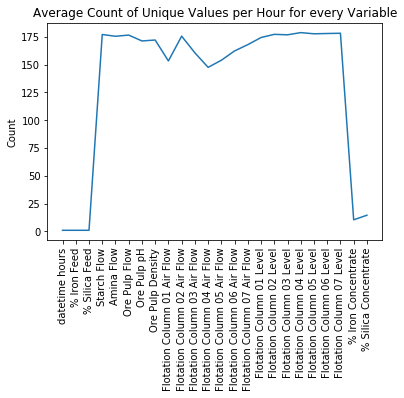

In [11]:
unique_avg = []
for col in df.columns:
    unique_avg.append(df.groupby('datetime hours').apply(lambda x: len(x[col].unique())).mean())
plt.plot(np.arange(len(unique_avg)), unique_avg)
plt.title('Average Count of Unique Values per Hour for every Variable')
plt.ylabel('Count')
plt.xticks(list(range(len(unique_avg))), list(df.columns), rotation='vertical')
plt.show()

Only the Iron and Silica Feed and Concentrate variables seem hourly, the rest seems to contain higher frequency measurements. Yet, the unique averages are much higher than 1 for Silica Concentrate especially, which could indicate some inconsistencies.

### Interpolation Cleaning

We further checked individual variables to see if there are any outliers etc. We noticed that there seemed to be some interpolated values which can be detrimental to any modelling attempts.

datetime hours
2017-03-12 12:00:00    180
2017-03-30 20:00:00    180
2017-04-02 08:00:00    180
2017-04-02 09:00:00    180
2017-04-03 01:00:00    180
dtype: int64


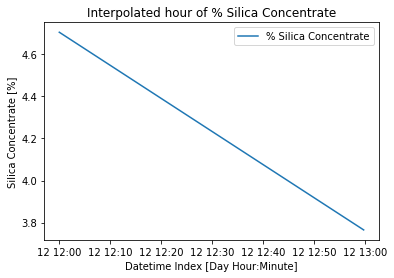

In [12]:
# some values for Silica Concentration seem interpolated so we're removing the values for all those hours
#some imports
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#get list of % Silica Concentrate values, see the first 5 that have more than one hourly value
silica_unique = df.groupby('datetime hours').apply(lambda x: len(x['% Silica Concentrate'].unique()))
print(silica_unique[silica_unique > 1][:5])

# plot before the interpolations are taken out of the dataframe
plt.plot(df['% Silica Concentrate'][df['datetime hours'] == silica_unique[silica_unique > 1].index[0]])

# take out interpolated hours for % Silica Concentrate
interpolated_hours = silica_unique[silica_unique >1].index.format()
clean_df=df[~df['datetime hours'].isin(interpolated_hours)]

#finish the graph
plt.title('Interpolated hour of % Silica Concentrate')
plt.xlabel('Datetime Index [Day Hour:Minute]')
plt.ylabel('Silica Concentrate [%]')
plt.legend(loc='best')
plt.show()

Next, we will graph some of the input variables and check for more interpolations. Both Iron Feed and Silica Feed seem to have a large amount of interpolated values. 

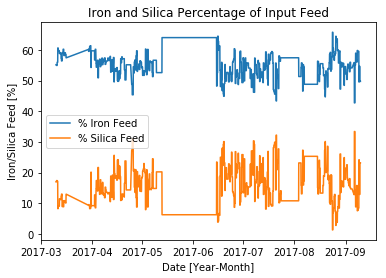

In [13]:
plt.plot(clean_df.index, clean_df['% Iron Feed'])
plt.plot(clean_df.index, clean_df['% Silica Feed'])
plt.title('Iron and Silica Percentage of Input Feed')
plt.legend(loc='best')
plt.ylabel('Iron/Silica Feed [%]')
plt.xlabel('Date [Year-Month]')
plt.show()

It seems that there are some missing values for the Iron and Silica Feed as well, so let us investigate the most frequently occuring values.

In [14]:
#if_unique = clean_df.groupby('datetime hours').apply(lambda x: len(x['% Iron Feed'].unique()))
#sf_unique = clean_df.groupby('datetime hours').apply(lambda x: len(x['% Silica Feed'].unique()))
#print(if_unique[if_unique > 1][:5])
print('Count of unique hours in cleaned df: ', len(clean_df.groupby('datetime hours').mean()))
print('Count of unique % Iron Feed values: ',len(clean_df['% Iron Feed'].unique()))
print('Count of unique % Silica Feed values: ',len(clean_df['% Silica Feed'].unique()))
print('Reference: Count of unique % Silica Concentrate values: ',len(clean_df['% Silica Concentrate'].unique()))

Count of unique hours in cleaned df:  3787
Count of unique % Iron Feed values:  275
Count of unique % Silica Feed values:  290
Reference: Count of unique % Silica Concentrate values:  441


In [15]:
# function to get unique values of a df column and their counts 
def get_unique_counts(column):
    df = pd.DataFrame()
    
    uv_list, count_list = list(column.unique()), []
    
    for uv in uv_list:
        count_list.append(len(column[column == uv]))
        
    df['unique_values'] = uv_list
    df['count'] = count_list
    return df

Less than 

In [16]:
if_unique = get_unique_counts(clean_df['% Iron Feed']).sort_values('count',ascending=False)
sf_unique = get_unique_counts(clean_df['% Silica Feed']).sort_values('count',ascending=False)
print(if_unique.head(10))
print(sf_unique.head(10))

     unique_values   count
111          64.03  132660
207          57.46   42840
214          48.81   33840
110          52.61   14400
29           56.65    9180
24           59.72    8640
220          55.53    7020
74           55.17    5580
208          51.34    5220
2            55.99    4860
     unique_values   count
113           6.26  132660
219          10.80   42840
227          25.31   33840
112          20.24   14400
23            9.22    8640
35           13.32    8640
111          14.83    8100
74           14.35    5580
220          23.16    5220
30           14.93    4680


The four highest frequencies show the same count for both variables, let's look at the graphs to confirm that these were interpolated.

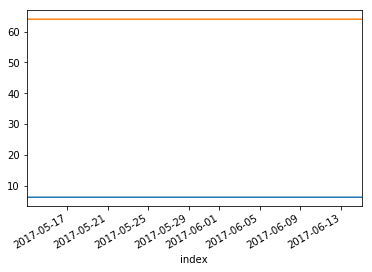

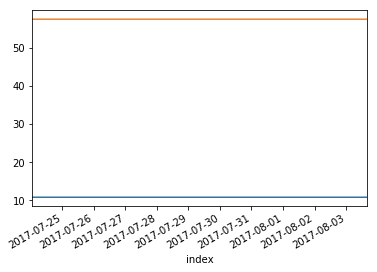

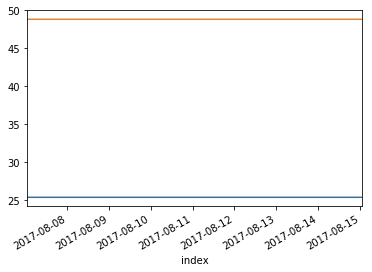

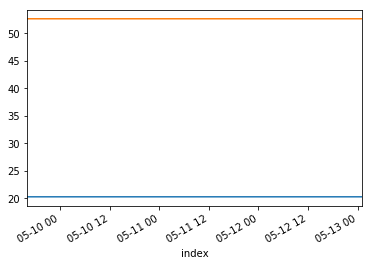

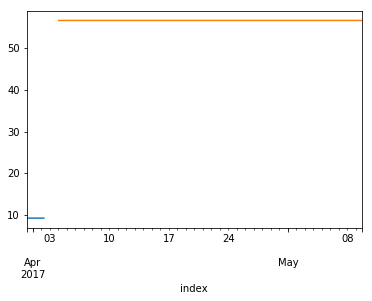

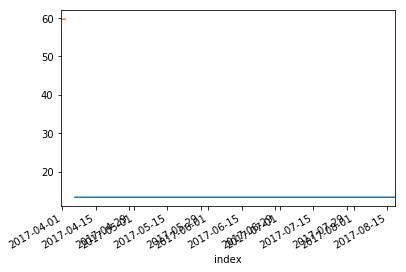

In [17]:
for i in range(6):
    clean_df['% Silica Feed'][clean_df['% Silica Feed'] == sf_unique.iloc[i,0]].plot()
    clean_df['% Iron Feed'][clean_df['% Iron Feed'] == if_unique.iloc[i,0]].plot() 
    plt.show()

In [18]:
clean_df.groupby([clean_df.index.date, clean_df.index.hour]).mean()

% Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
           index                                                        
2017-03-10 1            55.20          16.98  3162.625026  578.786678   
           2            55.20          16.98  3133.256389  537.219661   
           3            55.20          16.98  3479.482944  591.906744   
           4            55.20          16.98  3228.036436  593.170106   
           5            55.20          16.98  3327.280739  619.710806   
...                       ...            ...          ...         ...   
2017-09-09 19           49.75          23.20  3327.047776  497.211189   
           20           49.75          23.20  4225.800333  508.963856   
           21           49.75          23.20  2808.214692  517.748822   
           22           49.75          23.20  3191.497672  492.511228   
           23           49.75          23.20  3638.543653  460.769950   

                  Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
           index                                                 
2017-03-10 1         398.753368    10.113487          1.729558   
           2         399.871822    10.129742          1.667784   
           3         398.763806    10.048403          1.732711   
           4         399.866983     9.918614          1.731056   
           5         399.615089     9.746029          1.765879   
...                         ...          ...               ...   
2017-09-09 19        380.847200     9.176166          1.660871   
           20        381.112889     9.387541          1.691996   
           21        381.064411     9.771277          1.735647   
           22        380.445006     9.782121          1.716644   
           23        380.823147     9.653802          1.667825   

                  Flotation Column 01 Air Flow  Flotation Column 02 Air Flow  \
           index                                                               
2017-03-10 1                        251.166672                    250.226086   
           2                        249.880589                    250.214050   
           3                        250.161328                    250.104167   
           4                        250.208772                    250.204761   
           5                        249.917800                    250.160494   
...                                        ...                           ...   
2017-09-09 19                       301.565561                    300.169133   
           20                       300.050172                    299.967839   
           21                       299.814289                    299.801561   
           22                       300.122756                    299.679472   
           23                       299.778889                    300.095394   

                  Flotation Column 03 Air Flow  ...  \
           index                                ...   
2017-03-10 1                        250.178287  ...   
           2                        250.033317  ...   
           3                        250.046350  ...   
           4                        250.120861  ...   
           5                        250.013500  ...   
...                                        ...  ...   
2017-09-09 19                       299.900722  ...   
           20                       299.906550  ...   
           21                       299.973161  ...   
           22                       299.927028  ...   
           23                       299.840833  ...   

                  Flotation Column 07 Air Flow  Flotation Column 01 Level  \
           index                                                            
2017-03-10 1                        250.208184                 450.383776   
           2                        249.897572                 449.373361   
           3                        250.484183                 449.972878   
           4                        250.157622                 487.

I will remove the intervals that feature seemingly unclean data, i.e. the four highest frequency observations. 

223740 681653
(457913, 24)


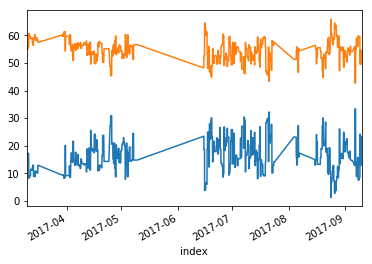

In [19]:
dirty_idx = []
for i in range(4):
    dirty_idx.extend(clean_df['% Silica Feed'][clean_df['% Silica Feed'] == sf_unique.iloc[i,0]].index.format())
dirty_idx
print(len(dirty_idx), len(clean_df))
clean_df=clean_df[~clean_df.index.isin(dirty_idx)]
print(clean_df.shape)
clean_df['% Silica Feed'].plot()
clean_df['% Iron Feed'].plot() 
plt.show()

### Correlation Plots

['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', '% Iron Concentrate', '% Silica Concentrate']


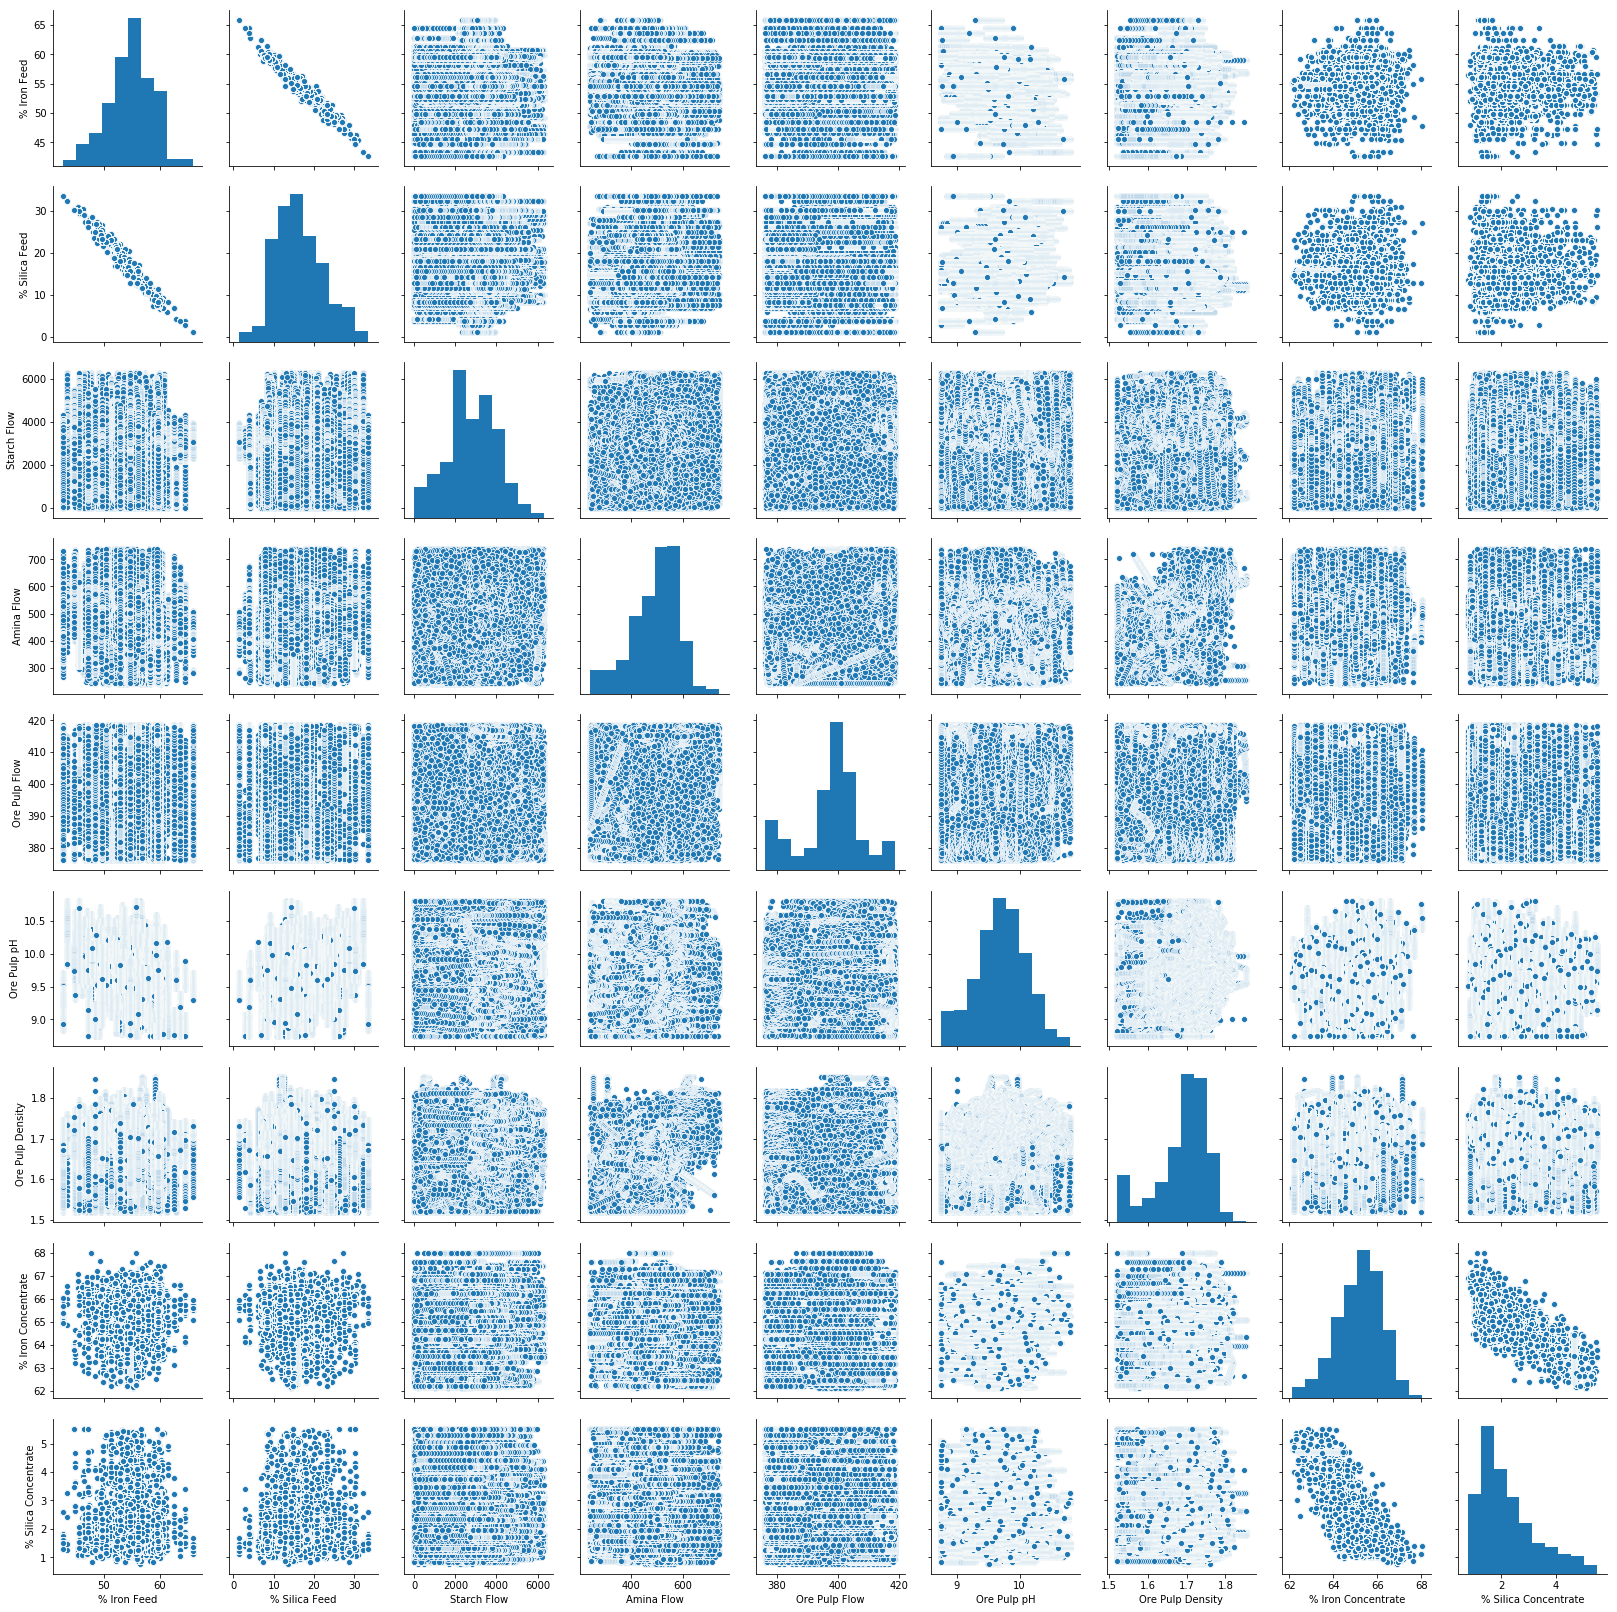

In [20]:
pair_cols = list(df.columns[1:8])
pair_cols.extend(df.columns[-2:])
print(pair_cols)
#smol_df = clean_df.loc[:,pair_cols]
sns.pairplot(clean_df.loc[:,pair_cols])
plt.show()

No apparent meaningful patterns besides between Iron and Silica Concentrate and Iron and Silica Feed (which are to be expected).

We also decided to check which minute of the hour showed the highest correlation with % Silica Concentrate for each variable. Our hypothesis was that they should peak around when the measurements where usually taken. 

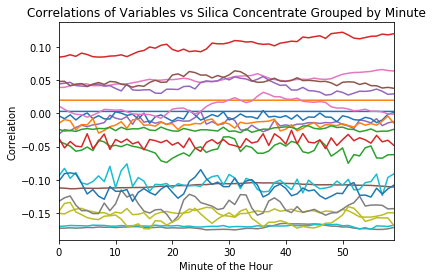

In [21]:
# minute correlations 
corr_df = pd.DataFrame(index=clean_df.columns[1:])
for minute in range(60):
    min_df = clean_df[clean_df.index.minute == minute]
    corr_df[str(minute)] = min_df.groupby([min_df.index.date, min_df.index.hour, min_df.index.minute]).mean().corr().iloc[:,-1]
corr_df = corr_df.transpose()

corr_df.iloc[:,:-2].plot(legend=False)
plt.title("Correlations of Variables vs Silica Concentrate Grouped by Minute")
plt.ylabel("Correlation")
plt.xlabel("Minute of the Hour")
plt.show()

In [22]:
def rmse(actual, preds):
    return np.sqrt(np.sum((np.array(actual)-np.array(preds))**2) / len(actual))
def mape(actual, preds):
    return np.sum(np.abs((np.array(actual)-np.array(preds))/(np.array(actual)))) / len(actual)
def mae(actual, preds):
    return np.sum(np.abs((np.array(actual)-np.array(preds)))) / len(actual)

### XDBoost

In [23]:
import xgboost as xgb

In [24]:
start=0
end=100

X = clean_df.iloc[start*24*180:end*24*180,1:-2]
y = clean_df.iloc[start*24*180:end*24*180,-1]
X_test = clean_df.iloc[(end)*24*180:,1:-2]
y_test = clean_df.iloc[(end)*24*180:,-1]

xgbr= xgb.XGBRegressor(max_depth=8, n_estimators=50, min_sample_split = 500, subsample=0.5, silent=True, colsample_bytree=0.8, gamma=100)

xgbr.fit(X,y)
print(xgbr.feature_importances_)
print(xgbr.score(X,y))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0.04158635 0.04942884 0.02337003 0.05228584 0.03215899 0.03394502
 0.02609181 0.07702395 0.01827085 0.12564535 0.05537816 0.030585
 0.13288191 0.03786972 0.02717398 0.03309095 0.03574713 0.04413743
 0.05542413 0.02278899 0.04511561]
0.6212528273568091


Train RMSE: 0.6534901864744599
RMSE: 1.1364326470653385
MAE: 0.869269757886158
MAPE: 0.36471237368706816


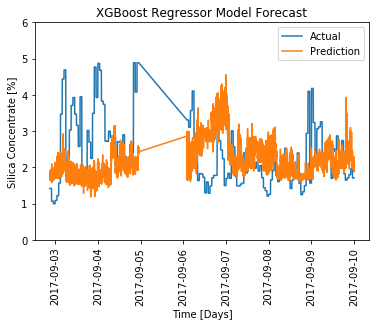

In [25]:
preds=xgbr.predict(X_test)
pred_df = pd.DataFrame(preds, columns=['predictions'])
print('Train RMSE: ' + str(rmse(y, xgbr.predict(X))))
print('RMSE: ' + str(rmse(y_test, preds)))
print('MAE: ' + str(mae(y_test, preds)))
print('MAPE: ' + str(mape(y_test, preds)))
plt.plot(y_test, label = 'Actual')
pred_df.index = y_test.index
plt.plot(pred_df, label = 'Prediction')
plt.legend()
plt.ylim(0,6)
plt.title('XGBoost Regressor Model Forecast')
plt.xticks(rotation='vertical')
plt.ylabel('Silica Concentrate [%]')
plt.xlabel('Time [Days]')
plt.show()

### Ridge Regression

In [26]:
from sklearn.linear_model import Ridge

start=0
end=100
X = clean_df.iloc[start*24*180:end*24*180,1:-2]
y = clean_df.iloc[start*24*180:end*24*180,-1]
X_test = clean_df.iloc[(end)*24*180:,1:-2]
y_test = clean_df.iloc[(end)*24*180:,-1]

rr= Ridge(alpha= 1, fit_intercept=False, normalize=True)

rr.fit(X,y)
print(rr.get_params)
print(rr.score(X,y))
print(rr.score(X_test,y_test))

<bound method BaseEstimator.get_params of Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)>
0.12092636376770083
-0.13316185520364487


Train RMSE:  0.9955819132261844
RMSE:  0.9660163493508769
MAPE:  0.331656182219891
MAE:  0.7512132477154428


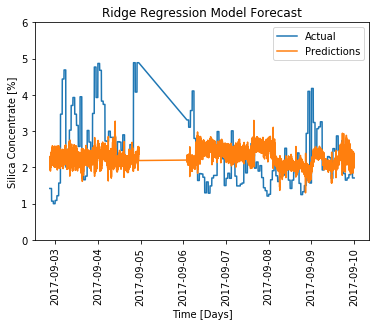

In [27]:
preds=rr.predict(X_test)
pred_df = pd.DataFrame(preds, columns=['predictions'])
y_pred= df.iloc[140*24*180:147*24*180,-1]
print('Train RMSE: ', rmse(y, rr.predict(X)))
print('RMSE: ', rmse(y_test, preds))
print('MAPE: ', mape(y_test, preds))
print('MAE: ', mae(y_test, preds))
plt.plot(y_test, label = 'Actual')
pred_df.index = y_test.index
plt.plot(pred_df, label = 'Predictions')
plt.title('Ridge Regression Model Forecast')
plt.xticks(rotation='vertical')
plt.ylabel('Silica Concentrate [%]')
plt.xlabel('Time [Days]')
plt.ylim(0,6)
plt.legend()
plt.show()

# Classification

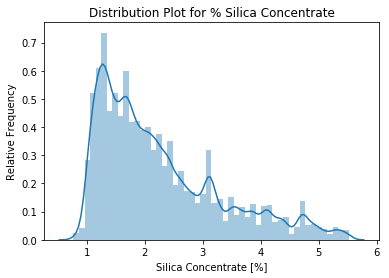

In [28]:
sns.distplot(clean_df['% Silica Concentrate'])
plt.title('Distribution Plot for % Silica Concentrate')
plt.ylabel('Relative Frequency')
plt.xlabel('Silica Concentrate [%]')
plt.show()

In [29]:
#create hour column
cdf = clean_df.copy(deep=True)
cdf['hour'] = cdf.index.hour

# get labels 
cdf['label'] = 0
cdf['label'][cdf['% Silica Concentrate'] > 3] = 1
print(cdf['label'][cdf['label'] == 1].count())
print(cdf['label'][cdf['label'] == 0].count())
print(cdf['label'][cdf['label'] == 0].count() / cdf['label'][cdf['label'] == 1].count())

102600
355313
3.4630896686159844


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [30]:
import random 

random.seed(69)
#start=0
#end=138

mdf = cdf.drop(columns = ['datetime hours', '% Iron Concentrate', '% Silica Concentrate'])

#create and sample train set for equal class distribution
#train = mdf.iloc[start*24*180:end*24*180]
train = mdf.iloc[:-14*24*180]
zero_idx = train[train['label'] == 0].index
sample_idx = random.sample(list(zero_idx), train[train['label'] == 1].shape[0])
sample_idx.extend(list(train[train['label'] == 1].index))
sample_idx = pd.DatetimeIndex(sample_idx).sort_values()
train = train.reindex(sample_idx)

X = train.iloc[:,:-1]
y = train.iloc[:,-1]

#X_eval = mdf.iloc[(end)*24*180:(end+7)*24*180,:-1]
#y_eval = mdf.iloc[(end)*24*180:(end+7)*24*180,-1]
#X_test = mdf.iloc[(end+7)*24*180:(end+14)*24*180,:-1]
#y_test = mdf.iloc[(end+7)*24*180:(end+14)*24*180,-1]
#X_eval = mdf.iloc[-14*24*180:-7*24*180,:-1]
#y_eval = mdf.iloc[-14*24*180:-7*24*180,-1]
X_test = mdf.iloc[-14*24*180:,:-1]
y_test = mdf.iloc[-14*24*180:,-1]

print(y[y == 0].count() / y[y==1].count())

1.0


### Initial XGBoost attempt

In [31]:
xgbc= xgb.XGBClassifier(max_depth=4, n_estimators=5, subsample=0.5, eval_metric='logloss', colsample_bytree=0.8, 
                        min_child_weight=100, gamma=50)

xgbc.fit(X,y)
print(xgbc.feature_importances_)
print(xgbc.score(X,y))

[0.08848646 0.06760378 0.         0.08585075 0.         0.
 0.04411155 0.         0.02604637 0.2147185  0.08779136 0.04635431
 0.         0.         0.         0.04271753 0.12097607 0.
 0.08487933 0.05959531 0.         0.03086859]
0.7215605749486653


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
preds=xgbc.predict(X_test)
results = confusion_matrix(y_test, preds) 
print('Test Set Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_test, preds) )
print('Report : ')
print(classification_report(y_test, preds))

Test Set Results
Confusion Matrix :
[[39972  5568]
 [13826  1114]]
Accuracy Score : 0.6793320105820105
Report : 
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     45540
           1       0.17      0.07      0.10     14940

    accuracy                           0.68     60480
   macro avg       0.45      0.48      0.45     60480
weighted avg       0.60      0.68      0.63     60480



In [33]:
eval_preds=xgbc.predict(X_eval)
eval_results = confusion_matrix(y_eval, eval_preds) 
print('Evaluation Set Results')
print('Confusion Matrix :')
print(eval_results) 
print('Accuracy Score :',accuracy_score(y_eval, eval_preds) )
print('Report : ')
print(classification_report(y_eval, eval_preds))

NameError: name 'X_eval' is not defined

In [34]:
train_preds=xgbc.predict(X)
train_results = confusion_matrix(y, train_preds) 
print('Training Set Results')
print('Confusion Matrix :')
print(train_results) 
print('Accuracy Score :',accuracy_score(y, train_preds) )
print('Report : ')
print(classification_report(y, train_preds))

Training Set Results
Confusion Matrix :
[[74332 13328]
 [35488 52172]]
Accuracy Score : 0.7215605749486653
Report : 
              precision    recall  f1-score   support

           0       0.68      0.85      0.75     87660
           1       0.80      0.60      0.68     87660

    accuracy                           0.72    175320
   macro avg       0.74      0.72      0.72    175320
weighted avg       0.74      0.72      0.72    175320



In [35]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
        #print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

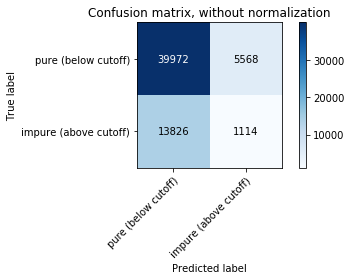

In [36]:
plot_confusion_matrix(np.array(y_test), np.array(preds), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)
plt.show()

## Grid Search

In [37]:
import random 

random.seed(69)
#start=0
end=-14

mdf = cdf.drop(columns = ['datetime hours', '% Iron Concentrate', '% Silica Concentrate'])

#create and sample train set for equal class distribution
#train = mdf.iloc[start*24*180:end*24*180]
train = mdf.iloc[:-14*24*180]
zero_idx = train[train['label'] == 0].index
sample_idx = random.sample(list(zero_idx), train[train['label'] == 1].shape[0])
sample_idx.extend(list(train[train['label'] == 1].index))
sample_idx = pd.DatetimeIndex(sample_idx).sort_values()
train = train.reindex(sample_idx)

X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_eval = mdf.iloc[(end)*24*180:(end+7)*24*180,:-1]
y_eval = mdf.iloc[(end)*24*180:(end+7)*24*180,-1]
X_test = mdf.iloc[(end+7)*24*180:,:-1]
y_test = mdf.iloc[(end+7)*24*180:,-1]
#X_test = mdf.iloc[-14*24*180:,:-1]
#y_test = mdf.iloc[-14*24*180:,-1]

print(y[y == 0].count() / y[y==1].count())

1.0


In [38]:
#max_depth_list = [5,7,10,15]
#n_trees_list  = [50, 75, 100, 150, 200]

#feature_1 = []
#feature_2 = []
#train_acc = []
#test_acc = []
#test_precision = []
#test_recall = []
#test_trueones = []

#for max_depth in max_depth_list:
#    for n_tree in n_trees_list:
#        xgbc= xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_tree, subsample=0.5, eval_metric='logloss', colsample_bytree=0.8, 
#                        min_child_weight=100, gamma=50)
#        
#        xgbc.fit(X,y)
#        pred = xgbc.predict(X_test)
#        
#        feature_1.append(max_depth)
#        feature_2.append(n_tree)
#        train_acc.append(xgbc.score(X,y))
#        test_acc.append(xgbc.score(X_test, y_test))
#        cm = confusion_matrix(y_test, pred) 
#        test_trueones.append(cm[1,1])
#        test_precision.append((cm[1,1]) / (cm[0,1] + cm[1,1]))
#        test_recall.append((cm[1,1]) / (cm[1,0] + cm[1,1]))
#        print(max_depth,n_tree)

In [39]:
#result_df = pd.DataFrame()
#result_df['feature_1'] = feature_1
#result_df['feature_2'] = feature_2
#result_df['train_acc'] = train_acc
#result_df['test_acc'] = test_acc
#result_df['test_precision'] = test_precision
#result_df['test_recall'] = test_recall
#result_df['test_trueones'] = test_trueones
#result_df

In [40]:
#max_depth_list2 = [2,3,4,5,6,8]
#n_trees_list2  = [3,5,6,7,8,9,10]#

#feature_12 = []
#feature_22 = []
#train_acc2 = []
#test_acc2 = []
#test_precision2 = []
#test_recall2 = []
#test_trueones2 = []

#for max_depth in max_depth_list2:
#    for n_tree in n_trees_list2:
#        xgbc= xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_tree, subsample=0.5, eval_metric='logloss', colsample_bytree=0.8, 
#                        min_child_weight=100, gamma=50)
#       
#        xgbc.fit(X,y)
#        pred = xgbc.predict(X_eval)
#        
#        feature_12.append(max_depth)
#        feature_22.append(n_tree)
#        train_acc2.append(xgbc.score(X,y))
 #       test_acc2.append(xgbc.score(X_eval, y_eval))
#        cm = confusion_matrix(y_eval, pred) 
#        test_trueones2.append(cm[1,1])
#        test_precision2.append((cm[1,1]) / (cm[0,1] + cm[1,1]))
#        test_recall2.append((cm[1,1]) / (cm[1,0] + cm[1,1]))
#        #print(max_depth,n_tree)

In [41]:
#result_df2 = pd.DataFrame()
#result_df2['max_depth'] = feature_12
#result_df2['n_trees'] = feature_22
#result_df2['train_acc'] = train_acc2
#result_df2['test_acc'] = test_acc2
#result_df2['test_precision'] = test_precision2
#result_df2['test_recall'] = test_recall2
#result_df2['test_trueones'] = test_trueones2
#result_df2

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
max_depth_list = [2,3,4,5]
n_trees_list  = [2,3,4,5,6,7,8]
min_child_weight_list = [10,50,100,200,300]
gamma_list = [1,10,30,50,100]

feature_1 = []
feature_2 = []
feature_3 = []
feature_4 = []
train_acc = []
test_acc = []
test_precision = []
test_recall = []
test_trueones = []

for max_depth in max_depth_list:
    for n_tree in n_trees_list:
        for min_child_weight in min_child_weight_list:
            for gamma in gamma_list:
                xgbc= xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_tree, subsample=0.5, eval_metric='logloss', #colsample_bytree=0.8, 
                        min_child_weight=min_child_weight, gamma=gamma)
       
                xgbc.fit(X,y)
                pred = xgbc.predict(X_eval)

                feature_1.append(max_depth)
                feature_2.append(n_tree)
                feature_3.append(min_child_weight)
                feature_4.append(gamma)
                train_acc.append(xgbc.score(X,y))
                test_acc.append(xgbc.score(X_eval, y_eval))
                cm = confusion_matrix(y_eval, pred) 
                test_trueones.append(cm[1,1])
                test_precision.append((cm[1,1]) / (cm[0,1] + cm[1,1]))
                test_recall.append((cm[1,1]) / (cm[1,0] + cm[1,1]))
                #print(max_depth,n_tree)

In [43]:
result_df3 = pd.DataFrame()
result_df3['max_depth'] = feature_1
result_df3['n_trees'] = feature_2
result_df3['min_child_weight'] = feature_3
result_df3['gamma'] = feature_4
result_df3['train_acc'] = train_acc
result_df3['test_acc'] = test_acc
result_df3['test_precision'] = test_precision
result_df3['test_recall'] = test_recall
result_df3['test_trueones'] = test_trueones
result_df3.to_csv('/kaggle/working/xgb_grid_search_results.csv')
result_df3

,max_depth,n_trees,min_child_weight,gamma,train_acc,test_acc,test_precision,test_recall,test_trueones
0,2,2,10,1,0.626232,0.720040,0.285714,0.000473,4
1,2,2,10,10,0.626232,0.720040,0.285714,0.000473,4
2,2,2,10,30,0.626232,0.720040,0.285714,0.000473,4
3,2,2,10,50,0.626232,0.720040,0.285714,0.000473,4
4,2,2,10,100,0.626232,0.720040,0.285714,0.000473,4
...,...,...,...,...,...,...,...,...,...
695,5,8,300,1,0.746292,0.683697,0.038429,0.005437,46
696,5,8,300,10,0.746298,0.683697,0.038429,0.005437,46
697,5,8,300,30,0.744456,0.677877,0.028698,0.004610,39
698,5,8,300,50,0.744456,0.677877,0.028698,0.004610,39


In [44]:
result_df3.sort_values(['test_trueones'], ascending=False).head(50)

,max_depth,n_trees,min_child_weight,gamma,train_acc,test_acc,test_precision,test_recall,test_trueones
549,5,2,300,100,0.714066,0.693022,0.342035,0.105319,891
548,5,2,300,50,0.714066,0.693022,0.342035,0.105319,891
547,5,2,300,30,0.714066,0.693022,0.342035,0.105319,891
545,5,2,300,1,0.714066,0.693022,0.342035,0.105319,891
546,5,2,300,10,0.714066,0.693022,0.342035,0.105319,891
324,3,7,300,100,0.668361,0.679795,0.276089,0.089125,754
320,3,7,300,1,0.668771,0.679828,0.276190,0.089125,754
321,3,7,300,10,0.668771,0.679828,0.276190,0.089125,754
322,3,7,300,30,0.668771,0.679828,0.276190,0.089125,754
323,3,7,300,50,0.668771,0.679828,0.276190,0.089125,754


In [45]:
result_df3.groupby([result_df3['max_depth'], result_df3['n_trees']])['test_trueones'].max()

max_depth  n_trees
2          2            4
           3            4
           4            4
           5            4
           6            4
           7           33
           8           34
3          2            4
           3            4
           4           46
           5           42
           6          751
           7          754
           8          115
4          2           51
           3           54
           4           59
           5           59
           6           59
           7           42
           8           42
5          2          891
           3          221
           4          212
           5          176
           6           39
           7           48
           8           48
Name: test_trueones, dtype: int64

In [46]:
result_df3[(result_df3['max_depth'] == 4) & (result_df3['n_trees'] == 8)]

,max_depth,n_trees,min_child_weight,gamma,train_acc,test_acc,test_precision,test_recall,test_trueones
500,4,8,10,1,0.732039,0.715112,0.164502,0.004492,38
501,4,8,10,10,0.732044,0.715112,0.164502,0.004492,38
502,4,8,10,30,0.732016,0.715112,0.164502,0.004492,38
503,4,8,10,50,0.731873,0.715112,0.164502,0.004492,38
504,4,8,10,100,0.730881,0.715112,0.164502,0.004492,38
505,4,8,50,1,0.741393,0.714716,0.156379,0.004492,38
506,4,8,50,10,0.741393,0.714716,0.156379,0.004492,38
507,4,8,50,30,0.741393,0.714716,0.156379,0.004492,38
508,4,8,50,50,0.741393,0.714716,0.156379,0.004492,38
509,4,8,50,100,0.741302,0.714716,0.156379,0.004492,38


In [47]:
xgbc= xgb.XGBClassifier(max_depth=5, n_estimators=2, subsample=0.5, eval_metric='logloss', min_child_weight = 300)

xgbc.fit(X,y)
print(xgbc.feature_importances_)
print(xgbc.score(X,y))

[0.0957562  0.12164047 0.05030685 0.09691955 0.         0.03552796
 0.         0.00138172 0.         0.25243354 0.10429649 0.04289853
 0.         0.         0.02478357 0.05216934 0.         0.
 0.03258289 0.06130669 0.         0.02799625]
0.7140657084188912


In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
preds=xgbc.predict(X_eval)
results = confusion_matrix(y_eval, preds) 
print('Test Set Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, preds) )
print('Report : ')
print(classification_report(y_eval, preds))

Test Set Results
Confusion Matrix :
[[20066  1714]
 [ 7569   891]]
Accuracy Score : 0.6930224867724868
Report : 
              precision    recall  f1-score   support

           0       0.73      0.92      0.81     21780
           1       0.34      0.11      0.16      8460

    accuracy                           0.69     30240
   macro avg       0.53      0.51      0.49     30240
weighted avg       0.62      0.69      0.63     30240



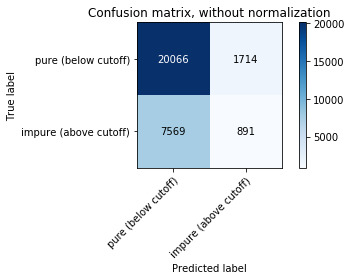

In [49]:
plot_confusion_matrix(np.array(y_eval), np.array(preds), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)
plt.show()

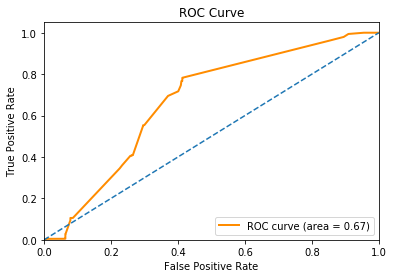

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(np.array(y_eval), xgbc.predict_proba(X_eval)[:,1])
roc_auc = roc_auc_score(np.array(y_eval), xgbc.predict_proba(X_eval)[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
xgbc= xgb.XGBClassifier(max_depth=3, n_estimators=7, subsample=0.5, eval_metric='logloss', min_child_weight=300)

xgbc.fit(X,y)
print(xgbc.feature_importances_)
print(xgbc.score(X,y))

[0.09109931 0.12966457 0.         0.09806565 0.         0.00957011
 0.         0.         0.00990069 0.20947714 0.12428251 0.
 0.         0.         0.         0.02351297 0.02912486 0.16785382
 0.         0.06302812 0.         0.04442032]
0.6687713894592745


Test Set Results
Confusion Matrix :
[[19804  1976]
 [ 7706   754]]
Accuracy Score : 0.6798280423280423
Report : 
              precision    recall  f1-score   support

           0       0.72      0.91      0.80     21780
           1       0.28      0.09      0.13      8460

    accuracy                           0.68     30240
   macro avg       0.50      0.50      0.47     30240
weighted avg       0.60      0.68      0.62     30240




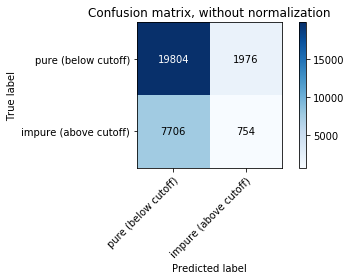

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
preds=xgbc.predict(X_eval)
results = confusion_matrix(y_eval, preds) 
print('Test Set Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, preds) )
print('Report : ')
print(classification_report(y_eval, preds))
plot_confusion_matrix(np.array(y_eval), np.array(preds), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)
plt.show()

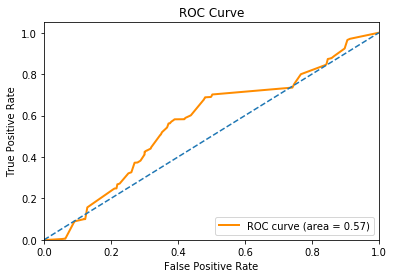

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(np.array(y_eval), xgbc.predict_proba(X_eval)[:,1])
roc_auc = roc_auc_score(np.array(y_eval), xgbc.predict_proba(X_eval)[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Logistic Reg

In [54]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=False, C=0.1)

lr.fit(X,y)
print(lr.decision_function(X))
print(lr.score(X,y))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[ 0.40571247  0.49041449  0.34283063 ... -0.52661461 -0.33283556
 -0.40648652]
0.6416096281086014


In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
preds=lr.predict(X_eval)
results = confusion_matrix(y_eval, preds) 
print('Test Set Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, preds) )
print('Report : ')
print(classification_report(y_eval, preds))

Test Set Results
Confusion Matrix :
[[16871  4909]
 [ 4927  3533]]
Accuracy Score : 0.6747354497354497
Report : 
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     21780
           1       0.42      0.42      0.42      8460

    accuracy                           0.67     30240
   macro avg       0.60      0.60      0.60     30240
weighted avg       0.67      0.67      0.67     30240



#### Grid

In [56]:
intercept_list = [True, False]
C_list  = [10,1,0.1,0.01,0.001,0.0001]

feature_1 = []
feature_2 = []
train_acc = []
test_acc = []
test_precision = []
test_recall = []
test_trueones = []

for C in C_list:
    for intercept in intercept_list:
        lr = LogisticRegression(fit_intercept=intercept, C=C, solver='liblinear')

       
        lr.fit(X,y)
        pred = lr.predict(X_eval)
        
        feature_1.append(C)
        feature_2.append(intercept)
        train_acc.append(lr.score(X,y))
        test_acc.append(lr.score(X_eval, y_eval))
        cm = confusion_matrix(y_eval, pred) 
        test_trueones.append(cm[1,1])
        test_precision.append((cm[1,1]) / (cm[0,1] + cm[1,1]))
        test_recall.append((cm[1,1]) / (cm[1,0] + cm[1,1]))
        #print(C,intercept)

In [57]:
result_df = pd.DataFrame()
result_df['C'] = feature_1
result_df['intercept'] = feature_2
#result_df['min_child_weight'] = feature_3
#result_df['gamma'] = feature_4
result_df['train_acc'] = train_acc
result_df['test_acc'] = test_acc
result_df['test_precision'] = test_precision
result_df['test_recall'] = test_recall
result_df['test_trueones'] = test_trueones
result_df

,C,intercept,train_acc,test_acc,test_precision,test_recall,test_trueones
0,10.0000,True,0.641883,0.675628,0.419846,0.417612,3533
1,10.0000,False,0.641627,0.674669,0.418384,0.417494,3532
2,1.0000,True,0.641587,0.674570,0.418255,0.417612,3533
3,1.0000,False,0.641655,0.674702,0.418415,0.417376,3531
4,0.1000,True,0.641661,0.674570,0.418216,0.417376,3531
5,0.1000,False,0.641610,0.674735,0.418503,0.417612,3533
6,0.0100,True,0.641997,0.675959,0.420928,0.421277,3564
7,0.0100,False,0.641650,0.674769,0.418359,0.416430,3523
8,0.0010,True,0.642020,0.675860,0.420573,0.419976,3553
9,0.0010,False,0.642186,0.675827,0.421232,0.424468,3591


In [58]:
C_list  = [10, 7.5, 5, 4, 3, 2,1,0.75, 0.5, 0.3, 0.1,0.05, 0.01]

feature_1 = []
feature_2 = []
train_acc = []
test_acc = []
test_precision = []
test_recall = []
test_trueones = []

for C in C_list:
    lr = LogisticRegression(fit_intercept=True, C=C, solver='liblinear')


    lr.fit(X,y)
    pred = lr.predict(X_eval)

    feature_1.append(C)
    #feature_2.append(intercept)
    train_acc.append(lr.score(X,y))
    test_acc.append(lr.score(X_eval, y_eval))
    cm = confusion_matrix(y_eval, pred) 
    test_trueones.append(cm[1,1])
    test_precision.append((cm[1,1]) / (cm[0,1] + cm[1,1]))
    test_recall.append((cm[1,1]) / (cm[1,0] + cm[1,1]))
    #print(C,intercept)

In [59]:
result_df2 = pd.DataFrame()
result_df2['C'] = feature_1
#result_df2['intercept'] = feature_2
result_df2['train_acc'] = train_acc
result_df2['test_acc'] = test_acc
result_df2['test_precision'] = test_precision
result_df2['test_recall'] = test_recall
result_df2['test_trueones'] = test_trueones
result_df2

,C,train_acc,test_acc,test_precision,test_recall,test_trueones
0,10.00,0.641883,0.675628,0.419846,0.417612,3533
1,7.50,0.641946,0.674339,0.420559,0.434279,3674
2,5.00,0.642117,0.675066,0.420894,0.429551,3634
3,4.00,0.641644,0.674735,0.418483,0.417494,3532
4,3.00,0.641661,0.674636,0.418354,0.417612,3533
5,2.00,0.641758,0.675496,0.419166,0.414657,3508
6,1.00,0.641587,0.674570,0.418255,0.417612,3533
7,0.75,0.641610,0.674702,0.418395,0.417258,3530
8,0.50,0.641872,0.675000,0.420280,0.426241,3606
9,0.30,0.641655,0.674636,0.418315,0.417376,3531


In [60]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=True, C=7.50, solver='liblinear')

lr.fit(X,y)

lr_preds= lr.predict(X_eval)

Logistic Regression Results
Confusion Matrix :
[[16718  5062]
 [ 4786  3674]]
Accuracy Score : 0.6743386243386243
Report: 
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     21780
           1       0.42      0.43      0.43      8460

    accuracy                           0.67     30240
   macro avg       0.60      0.60      0.60     30240
weighted avg       0.68      0.67      0.68     30240




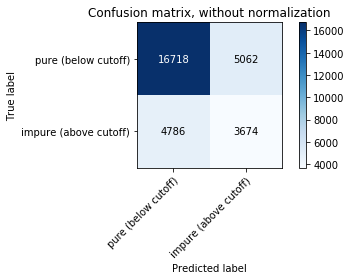

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
results = confusion_matrix(y_eval, lr_preds) 
print('Logistic Regression Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, lr_preds) )
print('Report: ')
print(classification_report(y_eval, lr_preds))
plot_confusion_matrix(np.array(y_eval), np.array(lr_preds), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)
plt.show()

### Putting it all together

In [62]:
import random 

random.seed(69)

mdf = df.drop(columns = ['datetime', '% Iron Concentrate', '% Silica Concentrate'])

train = mdf.iloc[:-14*24*180,:]
zero_idx = train[train['label'] == 0].index
sample_idx = random.sample(list(zero_idx), train[train['label'] == 1].shape[0])
sample_idx.extend(list(train[train['label'] == 1].index))
sample_idx = pd.DatetimeIndex(sample_idx).sort_values()
train = train.reindex(sample_idx)

X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_eval = mdf.iloc[-14*24*180:-7*24*180,:-1]
y_eval = mdf.iloc[-14*24*180:-7*24*180,-1]
X_test = mdf.iloc[-7*24*180:,:-1]
y_test = mdf.iloc[-7*24*180:,-1]

print(y[y == 0].count() / y[y==1].count())

KeyError: "['datetime'] not found in axis"

In [63]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=True, C=3.0, solver='liblinear')
xgbc= xgb.XGBClassifier(max_depth=2, n_estimators=2, eval_metric='logloss', subsample=0.5)
xgbc2 = xgb.XGBClassifier(max_depth=4, n_estimators=8, eval_metric='logloss', subsample=0.5, min_child_weight=300)

lr.fit(X,y)
xgbc.fit(X,y)
xgbc2.fit(X,y)

lr_preds= lr.predict(X_eval)
xgb_pred = xgbc.predict(X_eval)
xgb2_pred = xgbc2.predict(X_eval)

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
results = confusion_matrix(y_eval, xgb_pred) 
print('XGBoost Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, xgb_pred) )
print('Report: ')
print(classification_report(y_eval, xgb_pred))

XGBoost Results
Confusion Matrix :
[[21770    10]
 [ 8456     4]]
Accuracy Score : 0.7200396825396825
Report: 
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     21780
           1       0.29      0.00      0.00      8460

    accuracy                           0.72     30240
   macro avg       0.50      0.50      0.42     30240
weighted avg       0.60      0.72      0.60     30240



In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
results = confusion_matrix(y_eval, xgb2_pred) 
print('XGBoost Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, xgb2_pred) )
print('Report: ')
print(classification_report(y_eval, xgb2_pred))

XGBoost Results
Confusion Matrix :
[[20402  1378]
 [ 8418    42]]
Accuracy Score : 0.676058201058201
Report: 
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     21780
           1       0.03      0.00      0.01      8460

    accuracy                           0.68     30240
   macro avg       0.37      0.47      0.41     30240
weighted avg       0.52      0.68      0.58     30240



In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
results = confusion_matrix(y_eval, lr_preds) 
print('Logistic Regression Results')
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_eval, lr_preds) )
print('Report: ')
print(classification_report(y_eval, lr_preds))

Logistic Regression Results
Confusion Matrix :
[[16868  4912]
 [ 4927  3533]]
Accuracy Score : 0.6746362433862434
Report: 
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     21780
           1       0.42      0.42      0.42      8460

    accuracy                           0.67     30240
   macro avg       0.60      0.60      0.60     30240
weighted avg       0.67      0.67      0.67     30240



#### building an hourly classifier

In [67]:
eval_df = pd.DataFrame()
eval_df['LogReg'] = lr_preds
eval_df['XGBoost'] = xgb_pred
eval_df['XGBoost2'] = xgb2_pred
eval_df.index = y_eval.index
eval_df.head()

,LogReg,XGBoost,XGBoost2
index,,,
2017-08-25 02:00:00,0,0,0
2017-08-25 02:00:20,0,0,0
2017-08-25 02:00:40,0,0,0
2017-08-25 02:01:00,0,0,0
2017-08-25 02:01:20,0,0,0


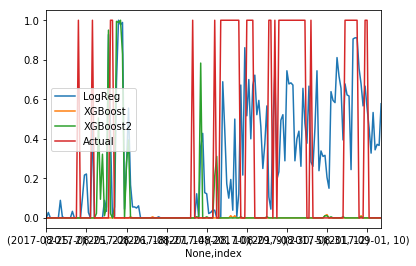

In [68]:
hour_counts = eval_df.groupby([eval_df.index.date, eval_df.index.hour]).sum() / 180
hour_counts['Actual'] = y_eval.groupby([y_eval.index.date, y_eval.index.hour]).mean()
hour_counts.plot()

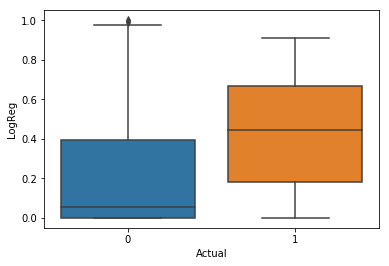

In [69]:
sns.boxplot(x="Actual", y="LogReg", data=hour_counts)

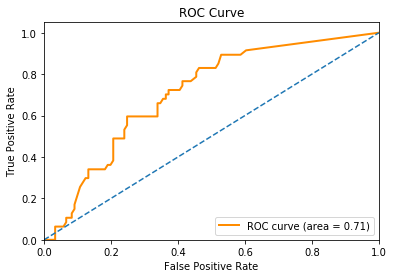

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(np.array(hour_counts["Actual"]), np.array(hour_counts["LogReg"]))
roc_auc = roc_auc_score(np.array(hour_counts["Actual"]), np.array(hour_counts["LogReg"]))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

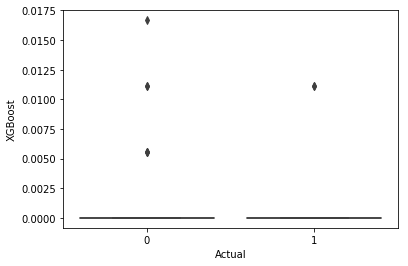

In [71]:
sns.boxplot(x="Actual", y="XGBoost", data=hour_counts)

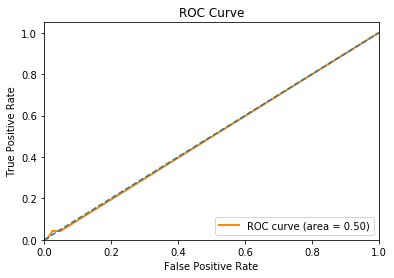

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(np.array(hour_counts["Actual"]), np.array(hour_counts["XGBoost"]))
roc_auc = roc_auc_score(np.array(hour_counts["Actual"]), np.array(hour_counts["XGBoost"]))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

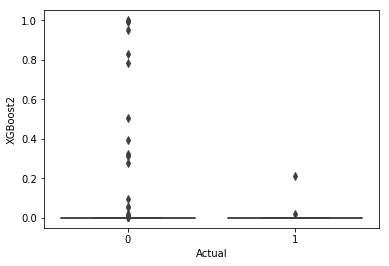

In [73]:
sns.boxplot(x="Actual", y="XGBoost2", data=hour_counts)

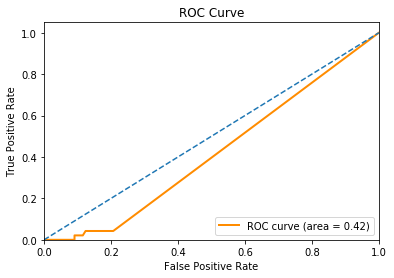

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(np.array(hour_counts["Actual"]), np.array(hour_counts["XGBoost2"]))
roc_auc = roc_auc_score(np.array(hour_counts["Actual"]), np.array(hour_counts["XGBoost2"]))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

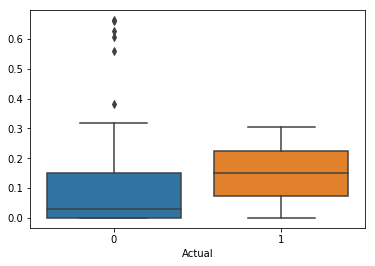

In [75]:
avg_eval_preds = (hour_counts['LogReg'] + hour_counts['XGBoost'] + hour_counts['XGBoost2']) / 3
sns.boxplot(x=hour_counts["Actual"], y=avg_eval_preds)

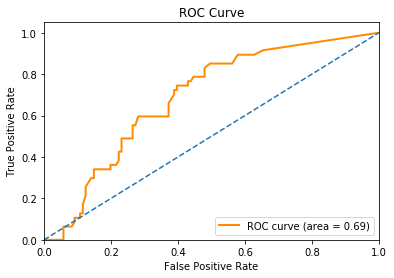

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(np.array(hour_counts["Actual"]), np.array(avg_eval_preds))
roc_auc = roc_auc_score(np.array(hour_counts["Actual"]), np.array(avg_eval_preds))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [77]:
cutoff_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
acc = []
truezeros = []
falsezeros = []
trueones = []
falseones = []
imp_precision = []
imp_recall = []

for cutoff in cutoff_list:
    ddf = pd.DataFrame(index=avg_eval_preds.index)
    ddf['class'] = 0
    ddf['class'][avg_eval_preds > cutoff] = 1
    
    cm = confusion_matrix(hour_counts["Actual"], ddf['class']) 
    acc.append((cm[1,1]+cm[0,0]) / len(ddf))
    truezeros.append(cm[0,0])
    falsezeros.append(cm[1,0])
    trueones.append(cm[1,1])
    falseones.append(cm[0,1])
    imp_precision.append((cm[1,1]) / (cm[0,1] + cm[1,1]))
    imp_recall.append((cm[1,1]) / (cm[1,0] + cm[1,1]))
    #print(C,intercept)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


In [78]:
cutoffs = pd.DataFrame()
cutoffs['Cutoff'] = cutoff_list
cutoffs['Accuracy'] = acc
cutoffs['True Zeros'] = truezeros
cutoffs['False Zeros'] = falsezeros
cutoffs['True Ones'] = trueones
cutoffs['False Ones'] = falseones
cutoffs['Impure Precision'] = imp_precision
cutoffs['Impure Recall'] = imp_recall
cutoffs

,Cutoff,Accuracy,True Zeros,False Zeros,True Ones,False Ones,Impure Precision,Impure Recall
0,0.10,0.619048,76,19,28,45,0.383562,0.595745
1,0.15,0.666667,89,24,23,32,0.418182,0.489362
2,0.20,0.708333,103,31,16,18,0.470588,0.340426
3,0.25,0.678571,111,44,3,10,0.230769,0.063830
4,0.30,0.696429,114,44,3,7,0.300000,0.063830
5,0.35,0.684524,115,47,0,6,0.000000,0.000000
6,0.40,0.690476,116,47,0,5,0.000000,0.000000
7,0.45,0.690476,116,47,0,5,0.000000,0.000000
8,0.50,0.690476,116,47,0,5,0.000000,0.000000
9,0.55,0.690476,116,47,0,5,0.000000,0.000000


In [79]:
#for i in range(len(cutoff_list)):
#    ddf = pd.DataFrame(index=avg_eval_preds.index)
#    ddf['class'] = 0
#    ddf['class'][avg_eval_preds > cutoff_list[i]] = 1
#    
#    print(cutoff_list[i])
#    plot_confusion_matrix(np.array(hour_counts["Actual"]), np.array(ddf['class']), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)

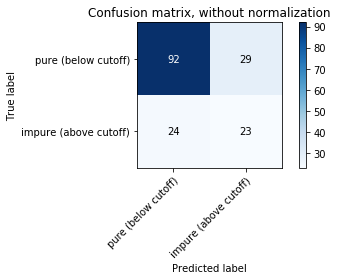

In [80]:
ddf = pd.DataFrame(index=hour_counts['LogReg'].index)
ddf['class'] = 0
ddf['class'][hour_counts['LogReg'] > 0.45] = 1

plot_confusion_matrix(np.array(hour_counts["Actual"]), np.array(ddf['class']), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)
plt.show()

### Apply method to Test Set

In [81]:
#import random #

#random.seed(69)

#mdf = df.drop(columns = ['datetime', '% Iron Concentrate', '% Silica Concentrate'])

#train = mdf.iloc[:-14*24*180]
#zero_idx = train[train['label'] == 0].index
#sample_idx = random.sample(list(zero_idx), train[train['label'] == 1].shape[0])
#sample_idx.extend(list(train[train['label'] == 1].index))
#sample_idx = pd.DatetimeIndex(sample_idx).sort_values()
#train = train.reindex(sample_idx)

#X = train.iloc[:,:-1]
#y = train.iloc[:,-1]

#X_eval = mdf.iloc[-42*24*180:-14*24*180,:-1]
#y_eval = mdf.iloc[-42*24*180:-14*24*180,-1]
#X_test = mdf.iloc[-14*24*180:,:-1]
#y_test = mdf.iloc[-14*24*180:,-1]

#print(y[y == 0].count() / y[y==1].count())

In [82]:
#lr = LogisticRegression(fit_intercept=True, C=3.0, solver='liblinear')
#xgbc= xgb.XGBClassifier(max_depth=2, n_estimators=2, eval_metric='logloss', subsample=0.5)
#xgbc2 = xgb.XGBClassifier(max_depth=4, n_estimators=8, eval_metric='logloss', subsample=0.5, min_child_weight=300)

#lr.fit(X,y)
#xgbc.fit(X,y)
#xgbc2.fit(X,y)

#lr_preds= lr.predict(X_eval)
#xgb_pred = xgbc.predict(X_eval)
#xgb2_pred = xgbc2.predict(X_eval)

In [83]:
#eval_df = pd.DataFrame()
#eval_df['LogReg'] = lr_preds
#eval_df['XGBoost'] = xgb_pred
#eval_df['XGBoost2'] = xgb2_pred
#eval_df.index = X_test.index
#hour_counts = eval_df.groupby([eval_df.index.date, eval_df.index.hour]).sum() / 180
#hour_counts['Actual'] = y_test.groupby([y_test.index.date, y_test.index.hour]).mean()
#hour_counts['Average'] = (hour_counts['LogReg'] + hour_counts['XGBoost'] + hour_counts['XGBoost2']) / 3
#hour_counts['Prediction'] = 0
#hour_counts['Prediction'][hour_counts['Average'] > 0.45] = 1
#plot_confusion_matrix(np.array(hour_counts["Actual"]), np.array(hour_counts["Prediction"]), classes=np.array(['pure (below cutoff)', 'impure (above cutoff)']), normalize=False)
#plt.show()

In [84]:
#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
#results = confusion_matrix(hour_counts["Actual"], hour_counts["Prediction"]) 
#print('Logistic Regression Results')
#print('Confusion Matrix :')
#print(results) 
#print('Accuracy Score :',accuracy_score(hour_counts["Actual"], hour_counts["Prediction"]) )
#print('Report: ')
#print(classification_report(hour_counts["Actual"], hour_counts["Prediction"]))